# ProtoPNet architecture with Hospital data

### Loading data & saving in numpy array

In [ ]:
# from math import ceil, isnan
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
from packaging import version


# Generates a string (the name of a sequence) from an int value
def sequence(number):
    number = str(number)
    if len(number) == 1: 
        
        number = '00' + number
    elif len(number) == 2:
        number = '0' + number
    name = 'SEQ'+number
    return name

# reads the frame's filename and returns the corresponding number
def frame_number(frame):
    nb = int(frame[5:frame.index('.')])
    return nb

# labels a frame f using a dataframe df
def label(f,df):
    a = 0
    if '2PB' in df.index:
            if float(df.loc['2PB'] != 0) and not(isnan(float(df.loc['2PB']))):
                x = ceil(12*float(df.loc['2PB']))
                if x<=f:
                    a = 1
    if '1PN' in df.index:
            if float(df.loc['1PN'] != 0) and not(isnan(float(df.loc['1PN']))):
                x = ceil(12*float(df.loc['1PN']))
                if x<=f:
                    a = 2
    if '2PN' in df.index:
            if float(df.loc['2PN'] != 0) and not(isnan(float(df.loc['2PN']))):
                x = ceil(12*float(df.loc['2PN']))
                if x<=f:
                    a = 2
    if '3PN' in df.index:
            if float(df.loc['3PN'] != 0) and not(isnan(float(df.loc['3PN']))):
                x = ceil(12*float(df.loc['3PN']))
                if x<=f:
                    a = 2
    if a==0: return [0]
    if a==1: return [1]
    if a==2: return [2]

DATA_DIR = r'/Users/khelifibilel/Untitled Folder 3/Untitled Folder/Hospital data'
N_SAMPLE = 110

X = []
Y = []
gray_imgs=[]
for index in range(N_SAMPLE):
    try:
        seq = sequence(index+1)
        df = pd.read_csv(DATA_DIR+'/'+seq+'.csv',header=None,index_col=0)
        frames = os.listdir(DATA_DIR+'/'+seq)
        images = [ cv2.resize(cv2.imread(DATA_DIR+'/'+seq+'/'+f),(180,180),interpolation = cv2.INTER_AREA) for f in frames]
        #for img in images:
         #   gray_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
        
        X.append(images)
        frames = [ frame_number(frame) for frame in frames]
        frames.sort()
        annots = []
        for f in frames:
            annots.append(label(f,df))
        Y.append(annots)

    
    except:
        print("error")

xPath='/Users/khelifibilel/Untitled Folder 3/Untitled Folder/HOSP_data/x_110.npy'
ypath='/Users/khelifibilel/Untitled Folder 3/Untitled Folder/HOSP_data/y_110.npy'

# save numpy array as npy file
from numpy import asarray,load
from numpy import save
# define data
data = asarray(X)
lab=asarray(Y)
# save to npy file

save(xPath, data)
save(ypath, lab)

In [13]:
## import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
import shutil

import torch.utils.data
import torchvision.datasets as datasets

import argparse
import re

import model
import push
import prune
import train_and_test as tnt
import save
from log import create_logger
from preprocess import mean, std, preprocess_input_function
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np

### Load dataset

In [14]:
xPath='/Users/khelifibilel/Untitled Folder 3/Untitled Folder/HOSP_data/x_110.npy'
ypath='/Users/khelifibilel/Untitled Folder 3/Untitled Folder/HOSP_data/y_110.npy'
import numpy as np
from numpy import load

# load array

X = load(xPath)
Y=load(ypath)
print(type(X),X.shape)
print(type(Y),Y.shape)

<class 'numpy.ndarray'> (110, 20, 180, 180, 3)
<class 'numpy.ndarray'> (110, 20, 1)


### Changing dimensionality

In [15]:
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)
X=np.moveaxis(X, -1, 2)    #to have channel, width, height

print(X.shape)
print(Y.shape)
X=X.reshape(2200,3,180,180)  # no sequences
Y=Y.reshape(2200,1)
print(X.shape)
print(Y.shape)
#weights=torch.tensor([0.57,0.54,0.88])  # will be used in CrossEntropyLoss
x_min = X.min(axis=(2,3), keepdims=True)
x_max = X.max(axis=(2,3), keepdims=True)

X = (X - x_min)/(x_max-x_min)



(110, 20, 180, 180, 3) (110, 20, 1)
(110, 20, 3, 180, 180)
(110, 20, 1)
(2200, 3, 180, 180)
(2200, 1)


### Spliting data to train & test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=7,stratify=Y)
print(X_train.shape)
print(X_test.shape)

(1870, 3, 180, 180)
(330, 3, 180, 180)


### Preprocess data & Oversampling the minority classe (tPN)

In [17]:
from torch.utils.data import TensorDataset, DataLoader,WeightedRandomSampler


BATCH_SIZE = 120

tensor_xt,tensor_xtest = torch.Tensor([X_train]),torch.Tensor([X_test]) # transform X to torch tensor
tensor_yt ,tensor_ytest= torch.Tensor([y_train]),torch.Tensor([y_test]) # transform Y to torch tensor

tensor_yt,tensor_ytest=tensor_yt.type(torch.LongTensor),tensor_ytest.type(torch.LongTensor)

tensor_xt,tensor_xtest=tensor_xt.view(1870,3, 180, 180),tensor_xtest.view(330,3, 180, 180)
tensor_yt,tensor_ytest=tensor_yt.view(1870),tensor_ytest.view(330)

print(tensor_xt.shape)
print(tensor_yt.shape)

trainData = TensorDataset(tensor_xt,tensor_yt) # create TRAINset

#FOR TRAINLOADER
# Oversample the minority classes
targets = tensor_yt
class_count = np.unique(targets, return_counts=True)[1]
print("Number of training images for each classes (before oversampling):",class_count)

weight = 1. / class_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)

# Here we have a balanced dataset due to oversampling
for batch_idx, (data, target) in enumerate(trainLoader):
    print('Batch {}, classes {}, count {}'.format(
        batch_idx, *np.unique(target.numpy(), return_counts=True)))
    # Your model will propably perform better here

# SAME THING TO TESTLOADER  
testData = TensorDataset(tensor_xtest,tensor_ytest) # create TESTtset

targets = tensor_ytest
class_count = np.unique(targets, return_counts=True)[1]
print()
print("Number of test images (before oversampling):",class_count)

test_weight = 1. / class_count
test_samples_weight = test_weight[targets]
test_samples_weight = torch.from_numpy(test_samples_weight)
testsampler = WeightedRandomSampler(test_samples_weight, len(test_samples_weight))

testLoader = DataLoader(testData, batch_size=BATCH_SIZE, sampler=testsampler, num_workers=2)

print("FOR TEST DATASET:")
# Here we have a balanced dataset due to oversampling
for batch_idx, (data, target) in enumerate(testLoader):
    print('Batch {}, classes {}, count {}'.format(
        batch_idx, *np.unique(target.numpy(), return_counts=True)))


torch.Size([1870, 3, 180, 180])
torch.Size([1870])
Number of training images for each classes (before oversampling): [965 699 206]
Batch 0, classes [0 1 2], count [31 47 42]
Batch 1, classes [0 1 2], count [35 40 45]
Batch 2, classes [0 1 2], count [35 40 45]
Batch 3, classes [0 1 2], count [38 38 44]
Batch 4, classes [0 1 2], count [41 41 38]
Batch 5, classes [0 1 2], count [37 48 35]
Batch 6, classes [0 1 2], count [37 45 38]
Batch 7, classes [0 1 2], count [37 37 46]
Batch 8, classes [0 1 2], count [41 36 43]
Batch 9, classes [0 1 2], count [34 49 37]
Batch 10, classes [0 1 2], count [41 44 35]
Batch 11, classes [0 1 2], count [38 39 43]
Batch 12, classes [0 1 2], count [35 40 45]
Batch 13, classes [0 1 2], count [47 38 35]
Batch 14, classes [0 1 2], count [37 36 47]
Batch 15, classes [0 1 2], count [24 27 19]

Number of test images (before oversampling): [170 124  36]
FOR TEST DATASET:
Batch 0, classes [0 1 2], count [32 44 44]
Batch 1, classes [0 1 2], count [40 46 34]
Batch 2, cl

In [18]:
print(tensor_xt.shape)
print(tensor_xtest.shape)


torch.Size([1870, 3, 180, 180])
torch.Size([330, 3, 180, 180])


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/khelifibilel/.pyenv/versions/3.8.6/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/khelifibilel/.pyenv/versions/3.8.6/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/khelifibilel/.pyenv/versions/3.8.6/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/khelifibilel/.pyenv/versions/3.8.6/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/khelifibilel/.pyenv/versions/3.8.6/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/khelifibilel/.pyenv/versions/3.8.6/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size]

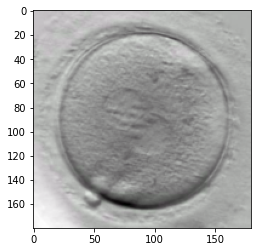

In [19]:
import matplotlib.pyplot as plt
import numpy as np
## functions to show an image

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

## get some random training images
dataiter = iter(trainLoader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images[33]))

In [20]:
for img, labels in trainLoader:
    print("Image batch dimensions:", img.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([120, 3, 180, 180])
Image label dimensions: torch.Size([120])


In [21]:
def makedir(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

In [23]:
import os
import shutil

import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import argparse
import re

import model
import push
import prune
import train_and_test as tnt
import save
from log import create_logger
from preprocess import mean, std, preprocess_input_function

### Defining model settings

In [22]:

base_architecture = 'resnet18'   # defining RESNET18 as a backbone
img_size = 180
prototype_shape = (12,128,1 , 1) # 4 prototypes per class
num_classes = 3
prototype_activation_function = 'log'
add_on_layers_type = 'regular'

experiment_run = 'HOSPITAL'


train_batch_size = 120
test_batch_size = 120
train_push_batch_size = 100

# defining the first LR values for the 3 phases

last_layer_optimizer_lr = 3e-4

joint_optimizer_lrs = {'features': 4e-3,             #training all layers SAUF FC
                       'add_on_layers': 1e-3,
                       'prototype_vectors': 1e-3}
joint_lr_step_size = 10

warm_optimizer_lrs = {'add_on_layers': 3e-3,          #training just additional & prototype layers 
                      'prototype_vectors': 3e-3}


coefs = {
    'crs_ent': 1,
    'clst': 0.8,
    'sep': -0.08,
    'l1': 1e-4,
}

num_train_epochs = 120
num_warm_epochs = 5

push_start = 8   # pushing prototypes starts after push_start epochs
push_epochs = [i for i in range(num_train_epochs) if i % 5 == 0 ]
print(push_epochs)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115]


### Defining warm and joint phases for training or not the backbone, and fitting the model

In [25]:

model_dir = './saved_models/' + base_architecture + '/' + experiment_run + '/'
makedir(model_dir)

log, logclose = create_logger(log_filename=os.path.join(model_dir, 'train.log'))
img_dir = os.path.join(model_dir, 'img')       #  for prototypes
makedir(img_dir)
weight_matrix_filename = 'outputL_weights'
prototype_img_filename_prefix = 'prototype-img'   # prefix of prototype imgs
prototype_self_act_filename_prefix = 'prototype-self-act'
proto_bound_boxes_filename_prefix = 'bb'


# train set
train_dataset = trainData
train_loader = trainLoader
# push set (for pushing prototypes)
train_push_dataset = trainData
train_push_loader = trainLoader
# test set
test_dataset = testData
test_loader =testLoader

log('training set size: {0}'.format(len(train_loader.dataset)))
log('push set size: {0}'.format(len(train_push_loader.dataset)))
log('test set size: {0}'.format(len(test_loader.dataset)))
log('batch size: {0}'.format(train_batch_size))

# construct the model

ppnet = model.construct_PPNet(base_architecture=base_architecture,
                              pretrained=True, img_size=img_size,
                              prototype_shape=prototype_shape,
                              num_classes=num_classes,
                              prototype_activation_function=prototype_activation_function,
                              add_on_layers_type=add_on_layers_type)
#if prototype_activation_function == 'linear':
#    ppnet.set_last_layer_incorrect_connection(incorrect_strength=0)
#ppnet = ppnet.cuda()
ppnet_multi = torch.nn.DataParallel(ppnet)
class_specific = True

# define optimize 
# joint_optimizer
joint_optimizer_specs = \
[{'params': ppnet.features.parameters(), 'lr': joint_optimizer_lrs['features'], 'weight_decay': 2e-3},           # For base layers    # bias are now also being regularized
 {'params': ppnet.add_on_layers.parameters(), 'lr': joint_optimizer_lrs['add_on_layers'], 'weight_decay': 2e-3}, # for additional l ayers
 {'params': ppnet.prototype_vectors, 'lr': joint_optimizer_lrs['prototype_vectors']},                            #for prototype layer
]
joint_optimizer = torch.optim.AdamW(joint_optimizer_specs)

joint_lr_scheduler = torch.optim.lr_scheduler.StepLR(joint_optimizer, step_size=joint_lr_step_size, gamma=0.3)   # divide lr by gamma every step_size epochs

# warm_optimizer
warm_optimizer_specs = \
[{'params': ppnet.add_on_layers.parameters(), 'lr': warm_optimizer_lrs['add_on_layers'], 'weight_decay': 1e-3},  # for additional layers
 {'params': ppnet.prototype_vectors, 'lr': warm_optimizer_lrs['prototype_vectors']},                             #for prototype layer
]
warm_optimizer = torch.optim.AdamW(warm_optimizer_specs)

# Fully connected optimizer
last_layer_optimizer_specs = [{'params': ppnet.last_layer.parameters(), 'lr': last_layer_optimizer_lr}]
last_layer_optimizer = torch.optim.AdamW(last_layer_optimizer_specs)

# weighting of different training losses

# train the model
log('start training')

for epoch in range(num_train_epochs):
    log('epoch: \t{0}'.format(epoch))

    if epoch < num_warm_epochs:      # first 5 epochs (if num_warm_epochs=5 ) # freezing base layers and optimizing additional+ prototype layers
        tnt.warm_only(model=ppnet_multi, log=log)
        _ = tnt.train(model=ppnet_multi, dataloader=train_loader, optimizer=warm_optimizer,
                      class_specific=class_specific, coefs=coefs, log=log)
    else:                            # optmizing base + additional + prototype layers
        tnt.joint(model=ppnet_multi, log=log)
        _ = tnt.train(model=ppnet_multi, dataloader=train_loader, optimizer=joint_optimizer,
                      class_specific=class_specific, coefs=coefs, log=log)
        joint_lr_scheduler.step()     # update weights

    accu = tnt.test(model=ppnet_multi, dataloader=test_loader,
                    class_specific=class_specific, log=log)
    save.save_model_w_condition(model=ppnet, model_dir=model_dir, model_name=str(epoch) + 'nopush', accu=accu,
                                target_accu=0.8, log=log)

    if epoch >= push_start and epoch in push_epochs:
        push.push_prototypes(
            train_push_loader, # pytorch dataloader (must be unnormalized in [0,1])
            prototype_network_parallel=ppnet_multi, # pytorch network with prototype_vectors
            class_specific=class_specific,
            preprocess_input_function=None, # normalize if needed
            prototype_layer_stride=1,
            root_dir_for_saving_prototypes=img_dir, # if not None, prototypes will be saved here
            epoch_number=epoch, # if not provided, prototypes saved previously will be overwritten
            prototype_img_filename_prefix=prototype_img_filename_prefix,
            prototype_self_act_filename_prefix=prototype_self_act_filename_prefix,
            proto_bound_boxes_filename_prefix=proto_bound_boxes_filename_prefix,
            save_prototype_class_identity=True,
            log=log)
        accu = tnt.test(model=ppnet_multi, dataloader=test_loader,
                        class_specific=class_specific, log=log)
        save.save_model_w_condition(model=ppnet, model_dir=model_dir, model_name=str(epoch) + 'push', accu=accu,
                                    target_accu=0.8, log=log)

        if prototype_activation_function != 'linear':
            tnt.last_only(model=ppnet_multi, log=log)       # last layer
            for i in range(6):
                log('iteration: \t{0}'.format(i))
                _ = tnt.train(model=ppnet_multi, dataloader=train_loader, optimizer=last_layer_optimizer,
                              class_specific=class_specific, coefs=coefs, log=log)
                accu = tnt.test(model= ppnet_multi, dataloader=test_loader,
                                class_specific=class_specific, log=log)
                save.save_model_w_condition(model=ppnet, model_dir=model_dir, model_name=str(epoch) + '_' + str(i) + 'push', accu=accu,
                                            target_accu=0.8, log=log)
logclose()   

training set size: 1870
push set size: 1870
test set size: 330
batch size: 120
start training
epoch: 	0
	warm
	train
	time: 	35.821
	cross ent: 	1.098
	cluster: 	4.441
	separation:	4.149
	avg separation:	9.774
	accu: 		32.246%
	l1: 		24.000
	p dist pair: 	18.016
	test
	time: 	6.982
	cross ent: 	1.092
	cluster: 	1.249
	separation:	1.079
	avg separation:	9.584
	accu: 		42.727%
	l1: 		24.000
	p dist pair: 	18.016
epoch: 	1
	warm
	train
	time: 	37.121
	cross ent: 	1.086
	cluster: 	0.569
	separation:	0.513
	avg separation:	9.547
	accu: 		38.663%
	l1: 		24.000
	p dist pair: 	17.711
	test
	time: 	6.790
	cross ent: 	1.079
	cluster: 	0.341
	separation:	0.303
	avg separation:	9.412
	accu: 		41.515%
	l1: 		24.000
	p dist pair: 	17.711
epoch: 	2
	warm
	train
	time: 	38.312
	cross ent: 	1.082
	cluster: 	0.317
	separation:	0.282
	avg separation:	9.354
	accu: 		41.872%
	l1: 		24.000
	p dist pair: 	17.669
	test
	time: 	7.269
	cross ent: 	1.063
	cluster: 	0.229
	separation:	0.201
	avg separation:	9.158

	time: 	43.615
	cross ent: 	1.314
	cluster: 	0.096
	separation:	0.079
	avg separation:	0.215
	accu: 		41.337%
	l1: 		23.782
	p dist pair: 	2.493
	test
	time: 	8.303
	cross ent: 	1.307
	cluster: 	0.095
	separation:	0.079
	avg separation:	0.215
	accu: 		43.333%
	l1: 		23.782
	p dist pair: 	2.493
iteration: 	3
	train
	time: 	43.230
	cross ent: 	1.279
	cluster: 	0.092
	separation:	0.078
	avg separation:	0.214
	accu: 		42.513%
	l1: 		23.755
	p dist pair: 	2.493
	test
	time: 	8.002
	cross ent: 	1.236
	cluster: 	0.094
	separation:	0.081
	avg separation:	0.217
	accu: 		50.606%
	l1: 		23.755
	p dist pair: 	2.493
iteration: 	4
	train
	time: 	44.267
	cross ent: 	1.281
	cluster: 	0.096
	separation:	0.079
	avg separation:	0.215
	accu: 		41.604%
	l1: 		23.729
	p dist pair: 	2.493
	test
	time: 	8.322
	cross ent: 	1.329
	cluster: 	0.097
	separation:	0.079
	avg separation:	0.213
	accu: 		42.424%
	l1: 		23.729
	p dist pair: 	2.493
iteration: 	5
	train
	time: 	45.677
	cross ent: 	1.267
	cluster: 	0.095
	

	time: 	10.999
	cross ent: 	1.024
	cluster: 	0.069
	separation:	0.059
	avg separation:	0.278
	accu: 		51.212%
	l1: 		23.592
	p dist pair: 	2.556
iteration: 	5
	train
	time: 	51.154
	cross ent: 	0.983
	cluster: 	0.064
	separation:	0.059
	avg separation:	0.281
	accu: 		51.176%
	l1: 		23.585
	p dist pair: 	2.556
	test
	time: 	9.219
	cross ent: 	1.008
	cluster: 	0.073
	separation:	0.060
	avg separation:	0.276
	accu: 		48.788%
	l1: 		23.585
	p dist pair: 	2.556
epoch: 	26
	joint
	train
	time: 	188.229
	cross ent: 	0.947
	cluster: 	0.063
	separation:	0.058
	avg separation:	0.290
	accu: 		53.583%
	l1: 		23.585
	p dist pair: 	2.556
	test
	time: 	20.863
	cross ent: 	0.995
	cluster: 	0.070
	separation:	0.059
	avg separation:	0.279
	accu: 		54.242%
	l1: 		23.585
	p dist pair: 	2.556
epoch: 	27
	joint
	train
	time: 	244.731
	cross ent: 	0.862
	cluster: 	0.064
	separation:	0.063
	avg separation:	0.293
	accu: 		59.091%
	l1: 		23.585
	p dist pair: 	2.554
	test
	time: 	13.480
	cross ent: 	1.130
	clust

	time: 	220.442
	cross ent: 	0.773
	cluster: 	0.056
	separation:	0.058
	avg separation:	0.288
	accu: 		64.599%
	l1: 		23.504
	p dist pair: 	2.647
	test
	time: 	11.720
	cross ent: 	0.928
	cluster: 	0.070
	separation:	0.059
	avg separation:	0.284
	accu: 		59.697%
	l1: 		23.504
	p dist pair: 	2.647
epoch: 	38
	joint
	train
	time: 	211.145
	cross ent: 	0.777
	cluster: 	0.056
	separation:	0.058
	avg separation:	0.301
	accu: 		63.209%
	l1: 		23.504
	p dist pair: 	2.647
	test
	time: 	15.628
	cross ent: 	1.066
	cluster: 	0.075
	separation:	0.059
	avg separation:	0.300
	accu: 		52.424%
	l1: 		23.504
	p dist pair: 	2.647
epoch: 	39
	joint
	train
	time: 	218.788
	cross ent: 	0.746
	cluster: 	0.056
	separation:	0.060
	avg separation:	0.302
	accu: 		66.203%
	l1: 		23.504
	p dist pair: 	2.647
	test
	time: 	12.630
	cross ent: 	1.109
	cluster: 	0.075
	separation:	0.058
	avg separation:	0.296
	accu: 		51.212%
	l1: 		23.504
	p dist pair: 	2.647
epoch: 	40
	joint
	train
	time: 	248.996
	cross ent: 	0.715

	time: 	9.113
	cross ent: 	1.046
	cluster: 	0.076
	separation:	0.058
	avg separation:	0.306
	accu: 		53.636%
	l1: 		23.457
	p dist pair: 	2.560
epoch: 	50
	joint
	train
	time: 	150.826
	cross ent: 	0.739
	cluster: 	0.057
	separation:	0.060
	avg separation:	0.314
	accu: 		65.455%
	l1: 		23.457
	p dist pair: 	2.560
	test
	time: 	9.488
	cross ent: 	1.093
	cluster: 	0.080
	separation:	0.057
	avg separation:	0.309
	accu: 		51.212%
	l1: 		23.457
	p dist pair: 	2.560
	push
	Executing push ...
	push time: 	45.5484459400177
	test
	time: 	7.405
	cross ent: 	1.049
	cluster: 	0.078
	separation:	0.061
	avg separation:	0.290
	accu: 		52.424%
	l1: 		23.457
	p dist pair: 	2.615
	last layer
iteration: 	0
	train
	time: 	38.437
	cross ent: 	0.787
	cluster: 	0.060
	separation:	0.061
	avg separation:	0.292
	accu: 		63.690%
	l1: 		23.455
	p dist pair: 	2.615
	test
	time: 	7.753
	cross ent: 	0.995
	cluster: 	0.076
	separation:	0.063
	avg separation:	0.290
	accu: 		55.455%
	l1: 		23.455
	p dist pair: 	2.615
i

KeyboardInterrupt: 